In [122]:
# !pip install torch
# !pip install torchvision

#### Imports

- `torch`, `torch.nn`, `torch.optim`: For building and training the model.
- `datasets`, `transforms`: To load and preprocess data.
- `tqdm`: For progress bars.
- `numpy`, `matplotlib.pyplot`: For numerical operations and plotting.
- `make_grid`: To visualize images.

#### Device Setup

Sets the computation device to GPU if available, otherwise defaults to CPU.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### FCVAE Class

A fully connected Variational Autoencoder (VAE) with the following components:

- **Encoder**:
  - Three fully connected layers (`fc1`, `fc2`, `fc3`) that transform the input to a latent space.
  - Two additional layers (`fc_mu`, `fc_logvar`) for computing the mean (`mu`) and log-variance (`logvar`) of the latent variable.

- **Latent to Hidden**:
  - A fully connected layer (`z_fc`) that maps the latent vector to a hidden space.

- **Decoder**:
  - Three fully connected layers (`fc4`, `fc5`, `fc6`) that reconstruct the input from the latent variable.

- **Methods**:
  - `encode(x)`: Encodes the input `x` into `mu` and `logvar`.
  - `reparameterize(mu, logvar)`: Applies the reparameterization trick to sample from the latent space.
  - `decode(z)`: Decodes the latent variable `z` back into the input space.
  - `forward(x)`: The full forward pass, combining encoding, reparameterization, and decoding.

In [2]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)
        
        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.z_fc(z))
        h = torch.relu(self.fc4(h))
        h = torch.relu(self.fc5(h))
        x_recon = torch.sigmoid(self.fc6(h))
        return x_recon.view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#### ConvVAE Class

A convolutional Variational Autoencoder (VAE) with the following components:

- **Encoder**:
  - Four convolutional layers (`conv1`, `conv2`, `conv3`, `conv4`) followed by batch normalization to extract features.
  - Two fully connected layers (`conv_mu`, `conv_logvar`) for generating the mean (`mu`) and log-variance (`logvar`) of the latent variable.

- **Latent Space**:
  - A fully connected layer (`z`) that maps the latent vector to the shape of the encoded features.

- **Decoder**:
  - Four transposed convolutional layers (`deconv1`, `deconv2`, `deconv3`, `deconv4`) followed by batch normalization to reconstruct the image from the latent vector.

- **Activation Functions**:
  - Leaky ReLU for the encoder and decoder layers.
  - Tanh activation in the final layer of the decoder for image output.

- **Methods**:
  - `encode(x)`: Encodes the input `x` into `mu` and `logvar`.
  - `reparameterize(mu, logvar)`: Samples from the latent space using the reparameterization trick.
  - `decode(z)`: Decodes the latent variable `z` back into the image space.
  - `forward(x)`: The full forward pass, combining encoding, reparameterization, and decoding.

In [3]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


#### Loss Function

- **MSE**: Measures reconstruction error.
- **KLD**: Regularizes the latent space.

#### Training

- Optimizes the VAE using MSE and KLD loss over multiple epochs.
- Progress is tracked with `tqdm`.

In [4]:
# Loss function
def loss_function(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

In [5]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'fcvae':
                recon_batch = recon_batch.view(-1, 3072)
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [6]:
num_epochs = 10
lr = 1e-3

#### Training the CVAE

- **Data Transformation**: Normalizes CIFAR-10 data for the CVAE.
- **DataLoader**: Loads training data with a batch size of 64.
- **Model**: Initializes the `ConvVAE` with a latent dimension of 128.
- **Optimizer**: Uses Adam optimizer with a learning rate of `lr`.
- **Training Loop**: Trains the model for `num_epochs` and tracks progress with the `train` function.

In [9]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:22<00:00, 34.26batch/s, kld_loss=41.3, recon_loss=280, train_loss=321]  


Epoch 1/10 train loss: 321.30677666015623 mse loss: 280.0428929589844 kld loss: 41.263883934326174


Epoch 2: 100%|██████████| 782/782 [00:22<00:00, 34.34batch/s, kld_loss=45.1, recon_loss=190, train_loss=235]  


Epoch 2/10 train loss: 234.95430986328125 mse loss: 189.81244275390625 kld loss: 45.14186710205078


Epoch 3: 100%|██████████| 782/782 [00:19<00:00, 40.65batch/s, kld_loss=48.3, recon_loss=173, train_loss=221]  


Epoch 3/10 train loss: 221.18820857421875 mse loss: 172.8873347363281 kld loss: 48.30087373168945


Epoch 4: 100%|██████████| 782/782 [00:19<00:00, 40.31batch/s, kld_loss=50.3, recon_loss=164, train_loss=214]   


Epoch 4/10 train loss: 214.36810927734376 mse loss: 164.09636385742186 kld loss: 50.271745279541015


Epoch 5: 100%|██████████| 782/782 [00:18<00:00, 43.31batch/s, kld_loss=51.5, recon_loss=159, train_loss=210]  


Epoch 5/10 train loss: 210.31829071289062 mse loss: 158.8118219189453 kld loss: 51.50646878417969


Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 43.39batch/s, kld_loss=52.7, recon_loss=155, train_loss=208]   


Epoch 6/10 train loss: 207.67612860351562 mse loss: 154.9640944921875 kld loss: 52.71203400878906


Epoch 7: 100%|██████████| 782/782 [00:18<00:00, 42.45batch/s, kld_loss=53.6, recon_loss=151, train_loss=205]  


Epoch 7/10 train loss: 204.99258139648438 mse loss: 151.38032900390624 kld loss: 53.61225282104492


Epoch 8: 100%|██████████| 782/782 [00:17<00:00, 43.56batch/s, kld_loss=54.3, recon_loss=149, train_loss=203]   


Epoch 8/10 train loss: 203.1777525439453 mse loss: 148.89730068359376 kld loss: 54.28045168457031


Epoch 9: 100%|██████████| 782/782 [00:18<00:00, 43.21batch/s, kld_loss=54.9, recon_loss=147, train_loss=202]  


Epoch 9/10 train loss: 201.52719533203125 mse loss: 146.6694266748047 kld loss: 54.85776846679688


Epoch 10: 100%|██████████| 782/782 [00:17<00:00, 44.25batch/s, kld_loss=55.3, recon_loss=145, train_loss=200]  

Epoch 10/10 train loss: 200.37082180664063 mse loss: 145.10527081054687 kld loss: 55.265550998535154


#### Training the FCVAE

- **Data Transformation**: Converts CIFAR-10 data to tensor format.
- **DataLoader**: Loads training data with a batch size of 64.
- **Model**: Initializes the `FCVAE` with input dimension 3072, hidden dimension 1000, and latent dimension 128.
- **Optimizer**: Uses Adam optimizer with a learning rate of `lr`.
- **Training Loop**: Trains the model for `num_epochs` using the `train` function.

In [10]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128).to(device)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:11<00:00, 67.49batch/s, kld_loss=5.98, recon_loss=129, train_loss=135]   


Epoch 1/10 train loss: 134.79647463623047 mse loss: 128.81459680419923 kld loss: 5.981877772445679


Epoch 2: 100%|██████████| 782/782 [00:11<00:00, 69.13batch/s, kld_loss=6.81, recon_loss=105, train_loss=111]   


Epoch 2/10 train loss: 111.49912534423828 mse loss: 104.69201631835938 kld loss: 6.80710896484375


Epoch 3: 100%|██████████| 782/782 [00:11<00:00, 67.48batch/s, kld_loss=7.38, recon_loss=97, train_loss=104]    


Epoch 3/10 train loss: 104.39260034179688 mse loss: 97.00911626220703 kld loss: 7.383484241333008


Epoch 4: 100%|██████████| 782/782 [00:11<00:00, 68.97batch/s, kld_loss=7.46, recon_loss=95.1, train_loss=103]   


Epoch 4/10 train loss: 102.59020806152344 mse loss: 95.13232938720704 kld loss: 7.45787866394043


Epoch 5: 100%|██████████| 782/782 [00:11<00:00, 67.77batch/s, kld_loss=7.65, recon_loss=94, train_loss=102]     


Epoch 5/10 train loss: 101.63996466308593 mse loss: 93.99078043457031 kld loss: 7.6491841604614255


Epoch 6: 100%|██████████| 782/782 [00:11<00:00, 68.98batch/s, kld_loss=8.58, recon_loss=91.3, train_loss=99.8]  


Epoch 6/10 train loss: 99.84665711669922 mse loss: 91.26229770996093 kld loss: 8.584359292907715


Epoch 7: 100%|██████████| 782/782 [00:12<00:00, 62.93batch/s, kld_loss=9.78, recon_loss=86.9, train_loss=96.7]  


Epoch 7/10 train loss: 96.71624569824219 mse loss: 86.93777524414062 kld loss: 9.778470581665038


Epoch 8: 100%|██████████| 782/782 [00:15<00:00, 51.67batch/s, kld_loss=10.2, recon_loss=83.3, train_loss=93.5]  


Epoch 8/10 train loss: 93.51372701416015 mse loss: 83.28213428222656 kld loss: 10.23159274383545


Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 68.59batch/s, kld_loss=10.7, recon_loss=81.7, train_loss=92.4]  


Epoch 9/10 train loss: 92.37060214355469 mse loss: 81.70304036621094 kld loss: 10.667561897277832


Epoch 10: 100%|██████████| 782/782 [00:11<00:00, 67.78batch/s, kld_loss=10.8, recon_loss=81, train_loss=91.8]    

Epoch 10/10 train loss: 91.80538154785157 mse loss: 80.97597314453125 kld loss: 10.829408399658202


#### Generating Images

- **Function**: Samples random points from the latent space and decodes them to generate images.
- **Evaluation Mode**: The model is set to evaluation mode with gradients turned off.
- **Image Rescaling**: The generated images are rescaled to the range [0, 1].
- **Display**: The generated images are displayed in a grid.

In [11]:
# Function to generate and display new images
def generate_images(model, model_name, num_images, latent_dim):
    if np.sqrt(num_images) % 1 != 0:
        raise ValueError('num_images must be a perfect square')
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    if model_name == 'cvae':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    grid_size = int(np.sqrt(num_images))

    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size + 1, grid_size + 1))
    axs = axs.flatten() if len(axs.shape) == 2 else axs
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 283.86image/s]


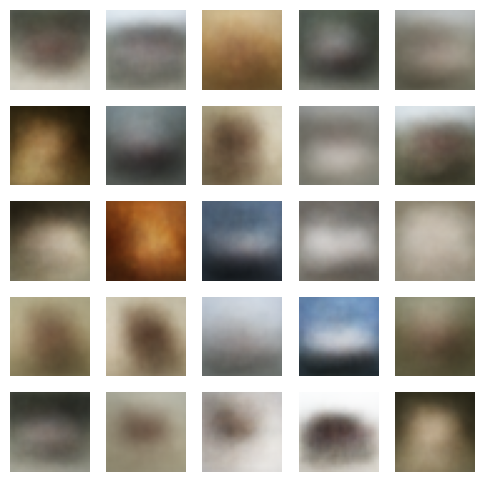

Images from Conv VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 219.25image/s]


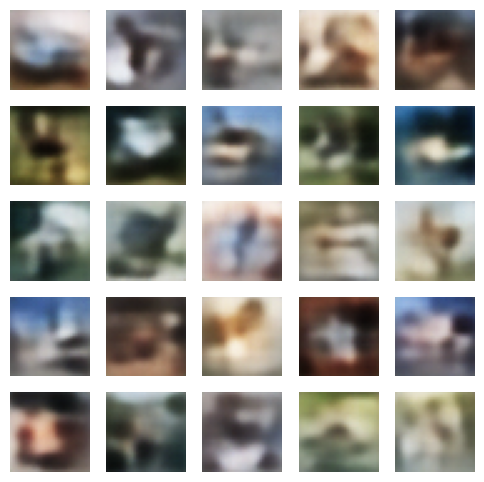

In [12]:
# Generate images
print('Images from FC VAE')
generate_images(fcvae, 'fcvae', num_images=25, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, 'cvae', num_images=25, latent_dim=128)

#### Image Interpolation

- **Function**: Interpolates between two images by encoding them into latent space, linearly blending their latent codes, and decoding the result.
- **Steps**:
  1. The images are encoded to latent representations.
  2. Latent codes are linearly interpolated over a specified number of steps.
  3. The interpolated latent codes are decoded back to images.
  4. The generated images are clamped to the [0, 1] range.
  
- **Visualization**: Displays the interpolated images in a horizontal grid.

In [13]:
def interpolate_images(model, model_name, image1, image2, device, num_steps=10):
    model.eval()
    with torch.no_grad():
        if model_name == 'cvae':
            if image1.shape[1] == 1:
                image1 = image1.repeat(1, 3, 1, 1)
            if image2.shape[1] == 1:
                image2 = image2.repeat(1, 3, 1, 1)
        image1 = image1.to(device)
        image2 = image2.to(device)
        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z2 + (1 - alpha) * z1
            reconstructed_image = model.decode(interpolated_z).cpu()
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
            interpolated_images.append(reconstructed_image)
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [14]:
def visualize_interpolation(model, model_name, dataset, num_steps=10):
    data_iter = iter(dataset)
    image1, _ = next(data_iter)
    image2, _ = next(data_iter)
    image1 = image1.unsqueeze(0).to(device)  # No need to flatten the image
    image2 = image2.unsqueeze(0).to(device)  # No need to flatten the image
    # Ensure 3 channels before passing to the model
    if image1.shape[1] == 1:
        image1 = image1.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    if image2.shape[1] == 1:
        image2 = image2.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axs[i].imshow(interpolated_images[i].permute(1, 2, 0).cpu().numpy())
        axs[i].axis('off')
    plt.show()

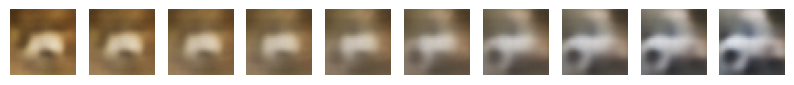

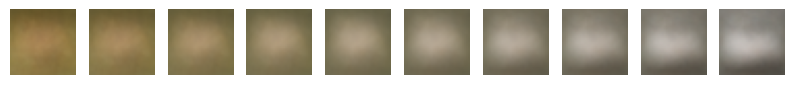

In [17]:
# Interpolate between two images from the dataset for Conv VAE
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=10)

# Interpolate between two images from the dataset for FC VAE
visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=10)